# Import modules

In [ ]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'
Plugins(categories=["generic"]).list()


# Load data and settings

In [ ]:
from DGE_data import get_real_and_synthetic

# let's restrict ourselves to classification datasets
datasets = ['moons', 'circles', 'breast_cancer',
            'adult',  'seer', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'tvae'  # synthetic data model

n_models = 20  # number of models in ensemble, for each run
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 10 # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models

# Whether to load and save models and synthetic datasets
load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False



# Experiments

## Model Training

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}

datasets = ['moons', 'circles', 'breast_cancer', 'adult', 'covid', 'seer']
num_runs=10
model_type = 'deepish_mlp'

for dataset in datasets:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)


    print(f'Dataset {dataset}\n')

    means, stds, _ = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            outlier=False, 
                                            task_type = model_type
                                            )

    print(means.to_latex())

    all_means[dataset] = means
    all_stds[dataset] = stds



In [ ]:
# Print results, aggregated over different datasets
means_consolidated = metric_different_datasets(all_means, to_print=False)
if num_runs>1:
    stds_consolidated = metric_different_datasets(all_stds, to_print=False)
    stds_consolidated.drop(columns=['Mean'], inplace=True)
    print(add_std(means_consolidated, stds_consolidated).to_latex())
else:
    print(means_consolidated.to_latex())

### Run over generative model sizes
Let us study what happens when we run the generative model for different sizes.

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd
genrun_all = {}
dataset = 'seer'

max_n = 5000
nsyn = 5000
model_type = 'deepish_mlp'
num_runs = 10

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)

    print(f'Model {model_name}\n')

    means, stds, all = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            task_type=model_type,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            )

    all['Hidden layers'] = layers
    genrun_all[layers] = all



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfs = pd.concat(genrun_all)
oracle = dfs[dfs['Approach']=='Oracle']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=='Naive (E)')]

metric = 'Acc'

sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect = 2, height=3, showfliers = False, legend=False)
plt.tight_layout()
#draw line for oracle mean
plt.axhline(oracle[metric].mean(), color='black', linestyle='--', label='$\mathcal{D}_R$-model')
plt.legend()
os.makedirs('results/stories', exist_ok=True)
plt.savefig(f'results/stories/training_models_{dataset}_max_n{max_n}_nsyn_{nsyn}_{model_type}_{metric}.png', dpi=300)
plt.show()

## Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Naive evaluation]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle evaluation]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [DGE evaluation]
6. Average over all models $f_i$. 

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [ ]:
from DGE_experiments import model_evaluation_experiment

evaluation_means = {}
evaluation_std = {}
relative = False
max_n = 5000
nsyn = 5000
model_name = 'ctgan_deep'
datasets = ['moons', 'circles', 'adult', 'seer', 'covid']
model_type = 'deepish_mlp'
verbose = False

for dataset in datasets:
    print('Dataset:', dataset)
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)


    

    # load data
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    # get mean and std of dataset over different runs
    means, std, _ = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type=model_type,
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             )

    evaluation_means[dataset] = means
    evaluation_std[dataset] = std


In [ ]:
# mean across datasets
# per dataset
metric = 'Acc'
res = metric_different_datasets(evaluation_means, metric=metric, to_print=False)
std_df = metric_different_datasets(evaluation_std, metric=metric, to_print=False)

del std_df['Mean']
res = add_std(res, std_df)
if relative != 'l2':
    print(res.to_latex(float_format=lambda x: '%.3f' % x))
else:
    print(res.to_latex(float_format=lambda x: '%.5f' % x))

### Vary the depth of the generative model


In [ ]:
from DGE_experiments import model_evaluation_experiment

genrun_means = {}
genrun_stds = {}
genrun_all = {}
dataset = 'seer'
relative = False
verbose = False

max_n = 5000
nsyn = 5000
n_models = 20

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)


    _, _, all = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type='deep_mlp',
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             outlier=outlier,
                                             )

    all['Hidden layers'] = layers
    genrun_all[layers] = all
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metric = 'AUC'
dfs = pd.concat(genrun_all,axis=0)
dfs.reset_index(inplace=True)
dfs['Hidden layers'] = dfs['level_0']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=="DGE (K=20)")|(dfs['Approach']=='Naive')|(dfs['Approach']=='Oracle')]
sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect=2, height = 3, showfliers=False, legend=False)
plt.legend()
plt.tight_layout()
plt.savefig(f'results/stories/eval_models_{dataset}_{metric}.png', dpi=300)
#draw line for oracle mean


In [ ]:
from DGE_experiments import model_evaluation_experiment

nsynrun_all = {}
dataset = 'seer'
relative = False

max_n = 5000
model_name = 'ctgan_deep'
n_models = 20
verbose = False
for nsyn in [1000, 5000, 20000]:

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)

   
    _, _, all = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type='deep_mlp',
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             outlier=outlier,
                                             )

    all['nsyn'] = nsyn
    nsynrun_all[nsyn] = all
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfs = pd.concat(nsynrun_all, axis=0)

metric = 'AUC'
dfs.reset_index(inplace=True)
dfs['Synthetic dataset size'] = dfs['level_0']
relative = False

if relative:
    oracle = dfs[(dfs['Approach']=='Oracle')]
    dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=="DGE (K=20)")|(dfs['Approach']=='Naive')]
    dfs -= oracle
else:
    dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=="DGE (K=20)")|(dfs['Approach']=='Naive')|(dfs['Approach']=='Oracle')]
sns.catplot(x='Synthetic dataset size', y=metric, data=dfs, kind='box', hue='Approach', aspect=2, height = 3, showfliers=False, legend=False)
plt.tight_layout()
plt.legend()
plt.savefig(f'results/stories/eval_nsyn_{dataset}_{metric}.png', dpi=300)
#draw line for oracle mean


## Model Selection
Essentially repeat the above for different models

In [ ]:
from DGE_experiments import model_selection_experiment

# load data
dataset = 'seer'
max_n = 5000
nsyn = 5000
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)



workspace_folder, results_folder = get_folder_names(
    dataset, model_name, max_n=max_n, nsyn=nsyn)

means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                    workspace_folder=workspace_folder, 
                                                    load=load, save=save)




In [ ]:
A = add_std(means_sorted[metric].iloc[:5], std[metric])
B = means_sorted[metric].iloc[5:]
B.index = [f'{i}'.replace(' rank','') for i in B.index]
B = B.astype(int)
B.columns = ['' for i in B.columns]
C = pd.concat([A, B], axis=1)
print(C.to_latex())


### Run for different synthetic dataset size (Appendix)

In [ ]:
from DGE_experiments import model_selection_experiment
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names
import numpy as np
import sklearn

# load data
dataset = 'seer'
max_n = 5000
p_train = 0.8
n_models = 20
model_name = 'ctgan_deep'
load=True
save = True
load_syn = True
verbose = False
means = {}
stds = {}
model_types = ['mlp', 'deepish_mlp', 'deep_mlp', 'largest_mlp']

for nsyn in [1000, 2000, 5000,10000,20000]:
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)



    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                        workspace_folder=workspace_folder, 
                                                        load=load, save=save, model_types=model_types )

    means[nsyn] = means_sorted
    stds[nsyn] = std


In [ ]:
x = means.keys()
metric = 'AUC'
from importlib import reload
import matplotlib.pyplot as plt
plt=reload(plt)
for i in range(len(means_sorted[metric])):    
    y = [means[j][metric].iloc[i] for j in x]
    labels = means[5000][metric].columns
    plt.semilogx(x, y, label=labels)
    plt.xlabel('Synthetic dataset size')
    name = means[5000][metric].index[i]
    if 'rank' in name:
        plt.ylabel('Ranking')
    else:
        plt.ylabel(metric)
    plt.legend()
    plt.savefig(f'results/stories/model_selection_mlps_nsyn_{name}_{metric}.png')
    plt.show()

## Underrepresented group

### Model training

In [ ]:
from DGE_data import get_real_and_synthetic
dataset = 'covid'
n_models = 20
num_runs = 10
max_n = 2000
nsyn = 2000
model_name = 'ctgan'
load = True
save = True
load_syn = True
verbose = False
reduce_to = None # used to get a very large set of real samples for evaluation (to accurately performance on small subgroups)


In [ ]:
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn,
                                        reduce_to=reduce_to)

# Get some indication of the distribution of the data
X_gt.train().data.hist()

Let us define the minority category for each feature

In [ ]:
import pandas as pd
from synthcity.plugins.core.dataloader import GenericDataLoader

def find_minority(data, feature):
    # Get the value that is the minority

    # turn data into dataframe if GenericDataLoader
    if type(data) != pd.DataFrame:
        data = data.data
    # find minority value
    if data[feature].unique().shape[0] < 20:

        counts = data[feature].value_counts()
        percentages = counts/counts.sum()
        counts = counts[percentages>0.005]
        value = counts.index[-1]
        percentage = percentages[value]
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]==value]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout
    else:
        quantile = 0.1
        threshold = data[feature].quantile(1-quantile)
        value = f'>={threshold:.2f}'
        percentage = quantile
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]>=threshold]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout

    return subset, value, percentage


In [ ]:
from DGE_experiments import predictive_experiment
from DGE_utils import get_folder_names
from synthcity.plugins.core.dataloader import GenericDataLoader

values = {}
results = {}
percentages = {}

workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

feature = 'ALL'
features = X_gt.unpack(as_numpy=False)[0].columns

_, _, res = predictive_experiment(X_gt,
                                    X_syns,
                                    workspace_folder=workspace_folder,
                                    results_folder=results_folder,
                                    save=save,
                                    load=load,
                                    plot=False,
                                    outlier=False
                                    )

results[feature] = res


for feature in features:
    subset, value, percentage = find_minority(X_gt.train(), feature)
    print(f'Feature {feature},\n minority value {value},\n minority percentage {percentage}')
    if percentage > 0.2:
        print('skipping due to not being minority')
        continue
    
    
    try:
        _, _, res = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            outlier=subset
                                            )
    except ValueError:
        print('Skipping due to too heavy imbalance making AUC non-computable')
        continue

    percentages[feature] = percentage
    values[feature] = value
    results[feature] = res



add the category name to each subset (just for plotting)

In [ ]:
results_copy = results.copy() # to got back if necessary

sorted_percentages = sorted(percentages.items(), key=lambda item: item[1])
sorted_percentages = dict(sorted_percentages)
#results_ = {f'{key}:{value} ({round(100*sorted_percentages[key],1)}%)': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = {f'{key}:{values[key]}': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = dict({'Overall':results['ALL']}, **results_)
results = results_

Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

normalize = True
if normalize:
    results_ = {}
    for key, res in results.items():
        results_key = []
        for group in res.groupby('Approach'):
            res_ = group[1].drop(columns='Approach')-res[res['Approach']=='Oracle'].drop(columns='Approach')
            res_['Approach'] = group[0]
            results_key.append(res_)
        results_key = pd.concat(results_key, axis=0)
        results_[key] = results_key
else:
    results_ = results.copy()

metric = 'AUC'
baseline = 'E'

df = pd.concat(results_)
df['Subset'] = df.index.get_level_values(0)

if normalize:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')] #|(df['Approach']=='DGE$_{20}$ (concat)')
else:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')|(df['Approach']=='Oracle')] #|(df['Approach']=='DGE$_{20}$ (concat)')
# draw a horizontal line at y=0
g = sns.catplot(data=df, hue='Approach', y=metric, x='Subset', kind='box', aspect=3, showfliers=False, legend=False)
g.set_xticklabels(rotation=20)
if normalize:
    plt.axhline(y=0, color='k', linestyle='--')
    g.set_ylabels(metric+r' on subset relative to $\mathcal{D}_R$-model')
plt.tight_layout()
plt.legend()
plt.savefig(f'results/stories/underrepresented_training_nsyn{nsyn}_nmax{max_n}_{metric}_{baseline}.png', dpi=300)


## Influence of synthetic data size (uncertainty plots and confidence curves)

Let's study the effect of synthetic data size. Resulting plots are saved in /results/

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}
model_name = 'ctgan'
n_models = 20
max_n = 2000
model_type = 'mlp'

for dataset in ['adult', 'seer', 'covid', 'gaussian', 'circles', 'moons']:
    for nsyn in [2000, 5000, 10000, 20000]:
        workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

        X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)


        print(f'Dataset {dataset}\n')

        means, stds, _ = predictive_experiment(X_gt,
                                                X_syns,
                                                workspace_folder=workspace_folder,
                                                results_folder=results_folder,
                                                task_type = model_type,
                                                save=save,
                                                load=load,
                                                plot=True,
                                                )



# Cross validation

In [ ]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'


/home/bv292/miniconda/envs/gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



['sdv_tvae',
 'nflow',
 'rtvae',
 'adsgan',
 'privbayes',
 'sdv_ctgan',
 'copulagan',
 'ctgan',
 'dpgan',
 'bayesian_network',
 'tvae',
 'pategan',
 'gaussian_copula']

In [ ]:
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names, tt_predict_performance, cat_dl
from DGE_data import get_real_and_synthetic
from DGE_experiments import cross_val
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# let's restrict ourselves to classification datasets
datasets = ['moons', 'circles', 'breast_cancer',
            'adult',  'seer', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'ctgan'  # synthetic data model

p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble, for each run
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5  # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models

load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False




In [ ]:
num_runs = 5
model_type = 'deepish_mlp'
model_name = 'ctgan'
nsyn = 5000
max_n = 2000
p_train = 0.8
n_models = 20
cross_fold = 5
load_syn = True
load = True
save = True
verbose = True

scores_s_all = {}
scores_r_all = {}

datasets = ['moons', 'circles', 'adult', 'seer', 'covid']

for dataset in ['seer']:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          p_train=p_train,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    print(f'Dataset {dataset}\n')

    scores_s, scores_r = cross_val(X_gt,
                                  X_syns,
                                  workspace_folder=workspace_folder,
                                  results_folder=results_folder,
                                  save=save,
                                  load=load,
                                  task_type=model_type,
                                  cross_fold=cross_fold,
                                  verbose=verbose
                                  )

    scores_s_all[dataset] = scores_s
    scores_r_all[dataset] = scores_r


n_total 20000 n_train: 2000
Dataset seer

Computing means and stds
Oracle
Run 0 approach Oracle split 0
Run 0 approach Oracle split 1
Run 0 approach Oracle split 2
Run 0 approach Oracle split 3
Run 0 approach Oracle split 4
Naive
Run 0 approach Naive split 0
Run 0 approach Naive split 1
Run 0 approach Naive split 2
Run 0 approach Naive split 3
Run 0 approach Naive split 4
DGE$_{20}$
Run 0 approach DGE$_{20}$ split 0
Run 0 approach DGE$_{20}$ split 1
Run 0 approach DGE$_{20}$ split 2
Run 0 approach DGE$_{20}$ split 3
Run 0 approach DGE$_{20}$ split 4
DGE$_{20}$ (concat)
Run 0 approach DGE$_{20}$ (concat) split 0
Run 0 approach DGE$_{20}$ (concat) split 1
Run 0 approach DGE$_{20}$ (concat) split 2
Run 0 approach DGE$_{20}$ (concat) split 3
Run 0 approach DGE$_{20}$ (concat) split 4
Oracle
Run 1 approach Oracle split 0
Run 1 approach Oracle split 1
Run 1 approach Oracle split 2
Run 1 approach Oracle split 3
Run 1 approach Oracle split 4
Naive
Run 1 approach Naive split 0
Run 1 approach Na

seer
                          AUC       Acc        F1  Precision    Recall  \
approach                                                                 
DGE$_{20}$           0.891685  0.816435  0.795660   0.813860  0.779506   
DGE$_{20}$ (concat)  0.891235  0.816010  0.795599   0.812098  0.780960   
Naive                0.871665  0.801000  0.784552   0.796922  0.774290   
Oracle               0.907072  0.839700  0.837993   0.847325  0.829780   

                          NLL     Brier  split  
approach                                        
DGE$_{20}$           0.417805  0.131421    2.0  
DGE$_{20}$ (concat)  0.419103  0.131782    2.0  
Naive                0.487104  0.145416    2.0  
Oracle               0.413746  0.120595    2.0  
                          AUC       Acc        F1  Precision    Recall  \
approach                                                                 
DGE$_{20}$           0.905688  0.826376  0.823714   0.836676  0.811564   
DGE$_{20}$ (concat)  0.905147  0.8

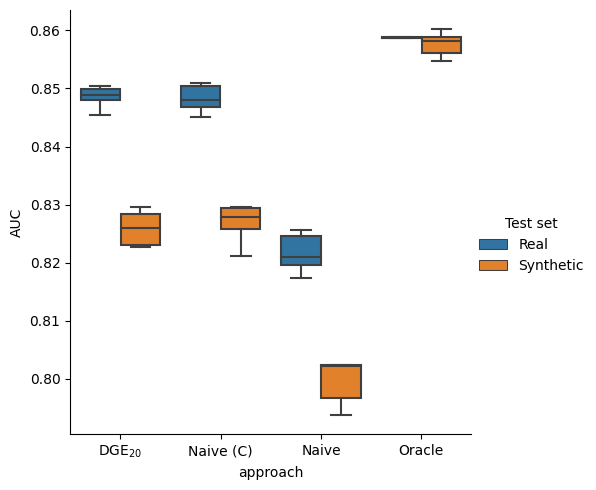

seer


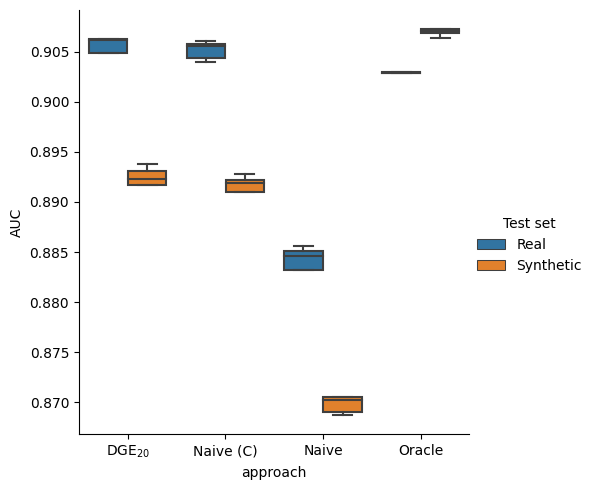

covid


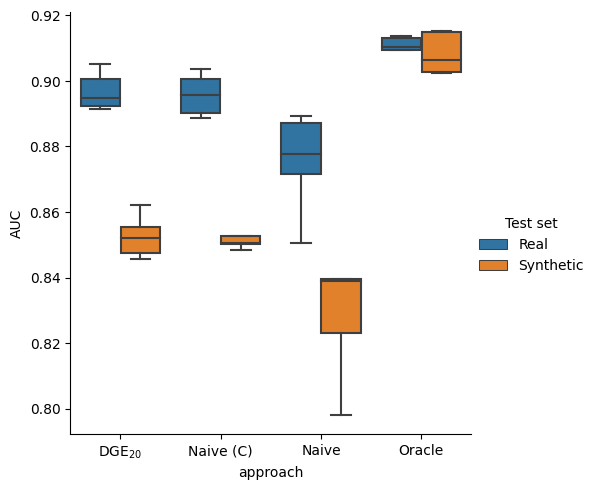

In [ ]:
metric = 'AUC'

for dataset in datasets[-3:]:
    print(dataset)
    scores_r_all[dataset]['Test set'] = 'Real'
    scores_s_all[dataset]['Test set'] = 'Synthetic'
    scores_ = pd.concat([scores_r_all[dataset], scores_s_all[dataset]],axis=0)
    scores_.reset_index(inplace=True)
    scores_.rename(columns={'index':'Approach'}, inplace=True)
    scores_ = scores_.mask(scores_ == 'DGE$_{20]$','DGE$_{20}$')
    scores_ = scores_.mask(scores_ == 'DGE$_{20}$ (concat)','Naive (C)')
    
    sns.catplot(data=scores_, x='approach', y=metric, hue='Test set', kind='box', showfliers=False)
    os.makedirs(f'./results/cross_val/', exist_ok=True)
    plt.savefig(f'./results/cross_val/{dataset}_{metric}_{model_name}_nsyn_{nsyn}_maxn{max_n}_{model_type}.png')
    plt.show()
